In [1]:
from pathlib import Path

import tensorflow as tf
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

2024-12-17 14:22:11.833091: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-17 14:22:11.859570: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-17 14:22:11.859599: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-17 14:22:11.859626: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-17 14:22:11.865993: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-17 14:22:11.866616: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

## Create Datasets

The datasets are created using the federated dataset for optimal comparability. The training time is a littlebit slower than with the `tensorflow_datasets` version, but the accuracy is roughly the same (difference of ~2% that I would attribute to randomness)

In [3]:
DATASET = "svhn_cropped"
SVHN_NUM_CLASSES = 10
SVHN_IMAGE_SHAPE = (32, 32, 3)

In [4]:
train_ds, val_ds = tfds.load(DATASET, split=['train[:80%]', 'train[80%:]'])
test_ds = tfds.load(DATASET, split='test')
len(train_ds), len(val_ds), len(test_ds)

(58606, 14651, 26032)

(<matplotlib.image.AxesImage at 0x781ad879d090>,
 <tf.Tensor: shape=(), dtype=int64, numpy=4>)

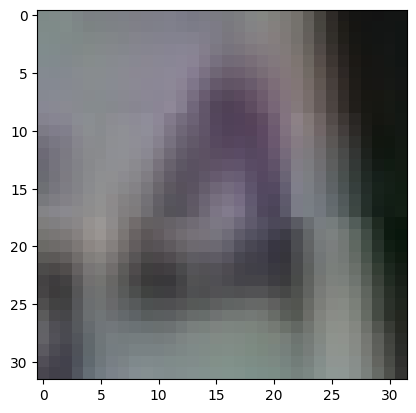

In [5]:
ex = next(iter(train_ds))
plt.imshow(ex['image']), ex['label']

In [6]:
augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomBrightness(0.3, value_range=(0.,1.)),
    tf.keras.layers.RandomContrast(0.5),
    tf.keras.layers.RandomRotation(factor=(-0.3,0.3))
])

In [7]:
def preprocess_ds(ds, is_train=False):
    def element_fn(element):
        image = element['image']
        label = element['label']
        # image = tf.cast(image, dtype=tf.float32) / 255.  # rescale image
        return (image, label)
    
    if is_train:
        return (
            ds
            .map(element_fn)
            .shuffle(128)
            # .repeat(3)
            # .map(lambda x, y: (augmentation(x), y))  # augmentation doesn't really help
            .batch(16)  # just increasing the batch size improved the training process a lot idk why
        )
    else:
        return (
            ds
            .map(element_fn)
            .batch(16)
        )

In [8]:
train = preprocess_ds(train_ds, is_train=True)
val = preprocess_ds(val_ds)
test = preprocess_ds(test_ds)

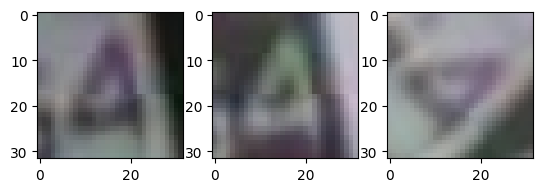

In [9]:
img = next(iter(train_ds))['image']
augmented_img = augmentation(tf.cast(img, dtype=tf.float32) / 255.)
fig, axes = plt.subplots(1,3)
axes[0].imshow(img)
axes[1].imshow(tf.image.adjust_contrast(img, -1.1))
axes[2].imshow(augmented_img)

## Models

In [10]:
from models import get_lucasnet, get_simple_cnn, get_mobilenet, get_efficientnet

In [11]:
def plot_history(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.legend(['train', 'val'], loc='upper left')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.show()

### Simple Convolutional Model

In [12]:
model = get_simple_cnn(SVHN_IMAGE_SHAPE, SVHN_NUM_CLASSES)

In [13]:
history = model.fit(
    train, 
    epochs=100, 
    validation_data=val,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)],
)
print(model.evaluate(test))

Epoch 1/100


3663/3663 [==============================] - 24s 6ms/step - loss: 1.1438 - accuracy: 0.6228 - val_loss: 0.5985 - val_accuracy: 0.8195
Epoch 2/100
3663/3663 [==============================] - 23s 6ms/step - loss: 0.6254 - accuracy: 0.8096 - val_loss: 0.4921 - val_accuracy: 0.8537
Epoch 3/100
3663/3663 [==============================] - 23s 6ms/step - loss: 0.5432 - accuracy: 0.8316 - val_loss: 0.4540 - val_accuracy: 0.8603
Epoch 4/100
3663/3663 [==============================] - 23s 6ms/step - loss: 0.5073 - accuracy: 0.8441 - val_loss: 0.4279 - val_accuracy: 0.8732
Epoch 5/100
3663/3663 [==============================] - 23s 6ms/step - loss: 0.4858 - accuracy: 0.8500 - val_loss: 0.3978 - val_accuracy: 0.8825
Epoch 6/100
3663/3663 [==============================] - 22s 6ms/step - loss: 0.4669 - accuracy: 0.8568 - val_loss: 0.4088 - val_accuracy: 0.8797
Epoch 7/100
1627/1627 [==============================] - 3s 2ms/step - loss: 0.4204 - accuracy: 0.8758
[0.42037734389305115, 0.875806689

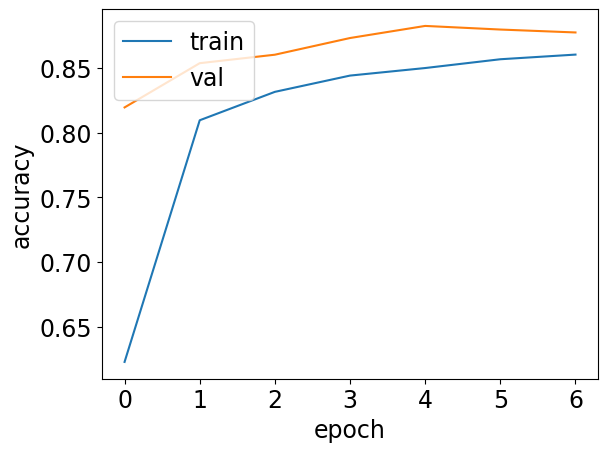

In [14]:
plt.rcParams.update({'font.size': 17})
plot_history(history)

### LL Architecture

In [14]:
model = get_lucasnet(SVHN_IMAGE_SHAPE, SVHN_NUM_CLASSES)

Epoch 1/100
3663/3663 ━━━━━━━━━━━━━━━━━━━━ 35s 7ms/step - accuracy: 0.6145 - loss: 1.2098 - val_accuracy: 0.8721 - val_loss: 0.4404
Epoch 2/100
3663/3663 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - accuracy: 0.8623 - loss: 0.4572 - val_accuracy: 0.8906 - val_loss: 0.3818
Epoch 3/100
3663/3663 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.8971 - loss: 0.3479 - val_accuracy: 0.8991 - val_loss: 0.3503
Epoch 4/100
3663/3663 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - accuracy: 0.9178 - loss: 0.2743 - val_accuracy: 0.9045 - val_loss: 0.3305
Epoch 5/100
3663/3663 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.9387 - loss: 0.2114 - val_accuracy: 0.9100 - val_loss: 0.3251
Epoch 6/100
3663/3663 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - accuracy: 0.9542 - loss: 0.1610 - val_accuracy: 0.9094 - val_loss: 0.3250
Epoch 7/100
3663/3663 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.9643 - loss: 0.1261 - val_accuracy: 0.9104 - val_loss: 0.3290
Epoch 8/100
3663/3663 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.9734 -

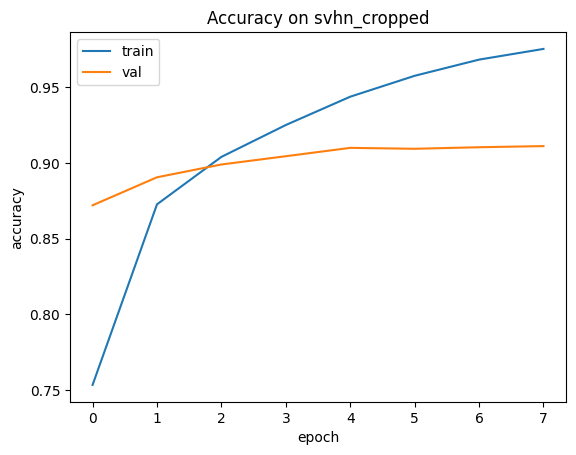

In [15]:
history = model.fit(
    train, 
    epochs=100, 
    validation_data=val,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)],
)
print(model.evaluate(test))
plot_history(history)